In [48]:
import numpy as np
import matplotlib.pylab as plt
import sys
np.set_printoptions(threshold=sys.maxsize)

In [49]:
FM = "test_20x20"
DP = "1000"
floormap = np.genfromtxt("../data/FM_" + FM)
# contains 1000 dipoles
dipoles = np.load("../data/FM_" + FM + "_DP_" + DP + ".npy", allow_pickle=True)
print(len(dipoles))

1000


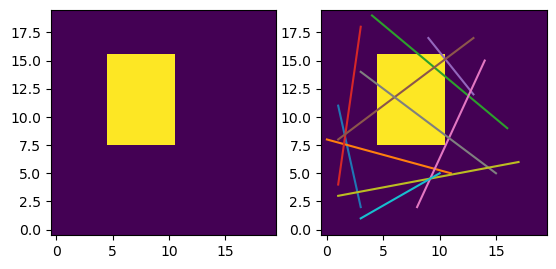

In [50]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(floormap, origin='lower')
plt.subplot(1,2,2)
plt.imshow(floormap, origin='lower')
for dipole in dipoles[:10]:
    #plotting the first 10 dipoles, have your own (X, Y) convention
    plt.plot([dipole[0][1], dipole[1][1]],[dipole[0][0], dipole[1][0]])
plt.show()

In [51]:
import bresenham

floor_ROW, floor_COL = np.shape(floormap)
blocked_pixels = set(
            list(zip(*np.where(floormap == 1)))  # floor == 1 means wall
    )
loss_block = 6 #attenuation in obstacles per unit length
loss_air = 2 #that for air
A = np.zeros((len(dipoles),(floor_ROW * floor_COL)))
B = []

index = 0
for dipole in dipoles:
    dimr = floor_ROW
    dimc = floor_COL

    x1 = dipole[0][1] #col
    y1 = dipole[0][0] #row
    x2 = dipole[1][1]
    y2 = dipole[1][0]
    path = list(bresenham.bresenham(x1, y1, x2, y2))

    sum = 0.0
    for p in path:
        if p in blocked_pixels:
            #more the random noise, poorer will be the reconstruction
            sum = sum + float(loss_block) + np.random.randint(0,4)
            A[index][(p[0] * floor_COL) + p[1]] = 1
        else :
            A[index][(p[0] * floor_COL) + p[1]] = 1
            sum = sum + float(loss_air) + np.random.randint(0,4)

    sum = round(sum, 2)
    index += 1
    B.append(sum)

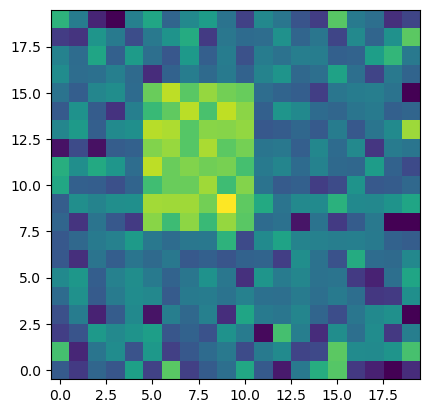

In [52]:
from scipy.optimize import nnls

num_variables = A.shape[1]
lambda_reg = 0.01

PROJ_TKNV = np.concatenate([A,
                            np.sqrt(lambda_reg) * np.eye(num_variables)
                            ])
RECV_TKNV = np.concatenate([B, np.zeros(num_variables)])
X, _ = nnls(PROJ_TKNV, RECV_TKNV)
image = X.reshape(floor_ROW, floor_COL)

plt.figure()
plt.imshow(image, origin='lower')
plt.show()